In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [98]:
df = pd.read_csv("/Users/nathr/Downloads/spy_yahoo.csv")
df = df.dropna()
df.head()
price_cols = ["Open", "High", "Low", "Close", "Volume"]
df[price_cols] = df[price_cols].apply(pd.to_numeric, errors="coerce")

## Step 1: Feature Engineering — ATR

We consider daily price range as a simple proxy for volatility.  
ATR is computed as a rolling mean of the daily high–low range and is used
to scale breakout thresholds in later steps.


In [101]:
def compute_atr(df, window=20):
    """
    Compute daily range and ATR (rolling mean of range)
    Returns a new DataFrame, no prints
    """
    df = df.copy()  # avoid SettingWithCopyWarning
    df["Range"] = df["High"] - df["Low"]
    df["ATR"] = df["Range"].rolling(window).mean()
    return df

## Step 2: Signal Generation — Volatility Breakout

A directional signal is generated when the daily price range exceeds a multiple
of recent volatility (ATR). The direction of the breakout is determined by the
sign of the open–close return.


In [104]:
def volatility_breakout_signal(df, k=1.5):
    """
    Generate +1/-1/0 signals based on volatility breakout.
    Fully pandas-native to avoid dimension issues.
    """
    df = df.copy()  # avoid SettingWithCopyWarning
    df["Signal"] = 0
    breakout_mask = df["Range"] > k * df["ATR"]
    df.loc[breakout_mask, "Signal"] = (df["Close"] - df["Open"]).apply(np.sign)[breakout_mask]
    return df

## Step 3: Position Construction

Signals are converted into positions held for a fixed number of days.
Overlapping signals are aggregated linearly.


In [107]:
def build_positions(df, holding_period=5):
    df = df.copy()
    df["Position"] = 0

    positions = df["Position"].values
    signals = df["Signal"].values

    for t in range(len(df)):
        if signals[t] != 0:
            start = t + 1
            end = min(t + 1 + holding_period, len(df))
            positions[start:end] += signals[t]

    df["Position"] = positions
    return df

## Step 4: Strategy Returns & Transaction Costs

Strategy returns are computed by applying lagged positions to daily asset returns.
Transaction costs are modeled as proportional to position turnover.


In [110]:
def compute_strategy_returns(df, cost_per_trade=0.001):
    """
    Compute daily returns and net strategy returns including transaction costs.
    """
    df = df.copy()
    # Daily returns of the asset
    df["Return"] = df["Close"].pct_change()

    # Strategy return based on previous day’s position
    df["StrategyReturn"] = df["Position"].shift(1) * df["Return"]

    # Turnover = absolute change in position
    df["Turnover"] = df["Position"].diff().abs()

    # Costs
    df["Cost"] = df["Turnover"] * cost_per_trade

    # Net returns
    df["NetStrategyReturn"] = df["StrategyReturn"] - df["Cost"]

    return df

## Results & Diagnostics

In [113]:
# Compute features
df = compute_atr(df, window=20)

# Generate signals
df = volatility_breakout_signal(df, k=1.5)

# Build positions
df = build_positions(df, holding_period=5)

# Compute returns including costs
df = compute_strategy_returns(df, cost_per_trade=0.001)

In [115]:
df[["NetStrategyReturn"]].describe()

,NetStrategyReturn
count,6535.000000
mean,-0.000288
std,0.011290
min,-0.291395
25%,-0.001000
50%,0.000000
75%,-0.000000
max,0.133735


### Equity Curve

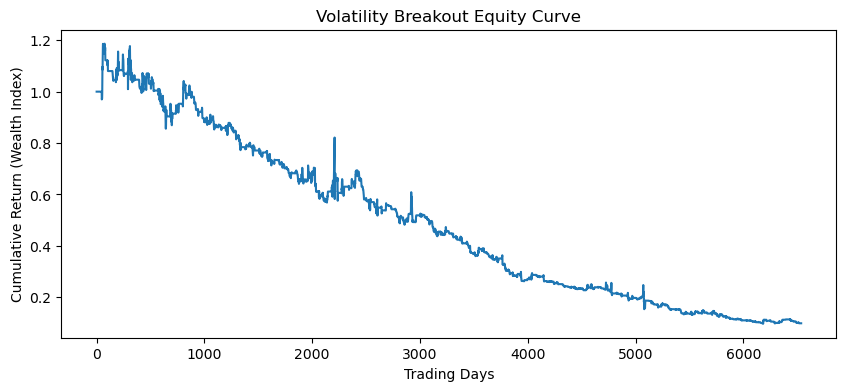

In [118]:
equity = (1 + df["NetStrategyReturn"].fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(equity)
plt.title("Volatility Breakout Equity Curve")
plt.xlabel("Trading Days")
plt.ylabel("Cumulative Return (Wealth Index)")
plt.show()

The equity curve exhibits a gradual decay over time with occasional positive spikes.
This pattern reflects a strategy that captures volatility expansions sporadically,
but suffers from persistent small losses and transaction costs on most days.
The distribution of returns is centered near zero with a heavy left tail,
indicating the absence of a persistent positive edge.


### Return Distribution

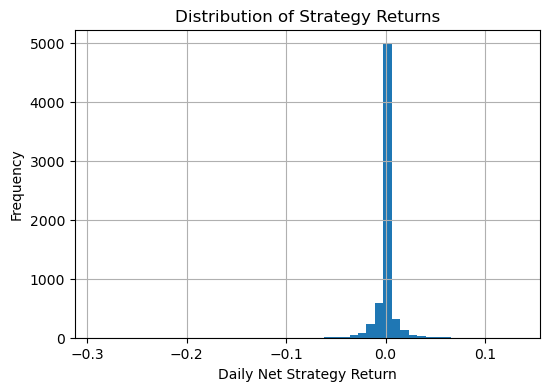

In [124]:
plt.figure(figsize=(6,4))
df["NetStrategyReturn"].hist(bins=50)
plt.title("Distribution of Strategy Returns")
plt.xlabel("Daily Net Strategy Return")
plt.ylabel("Frequency")
plt.show()

The distribution of daily net strategy returns exhibits a large mass at zero,
indicating that the strategy is inactive or generates negligible returns on most days.
Non-zero returns are negatively skewed, with small losses occurring more frequently
than small gains. While occasional large positive returns are observed,
they are insufficient in frequency to offset the accumulation of small losses
and transaction costs. This return distribution explains the gradual decay
observed in the equity curve.


### Robustness Check: High-Volatility Regime

Robustness checks assess whether the strategy’s performance persists
under different market conditions. Here, we condition on high-volatility
periods, defined as days when the ATR exceeds its 75th percentile. 

The rationale is that a volatility breakout strategy should theoretically
perform better when price swings are large. By comparing the high-volatility
equity curve and return distribution to the unconditional strategy, we
can test whether the signal retains an edge in favorable conditions or
if its failure is structural.


In [129]:
vol_threshold = df["ATR"].quantile(0.75)
high_vol = df["ATR"] > vol_threshold

high_vol_returns = df.loc[high_vol, "NetStrategyReturn"]
high_vol_returns.describe()

count    1629.000000
mean       -0.000506
std         0.016610
min        -0.291395
25%        -0.001000
50%         0.000000
75%         0.000000
max         0.133735
Name: NetStrategyReturn, dtype: float64

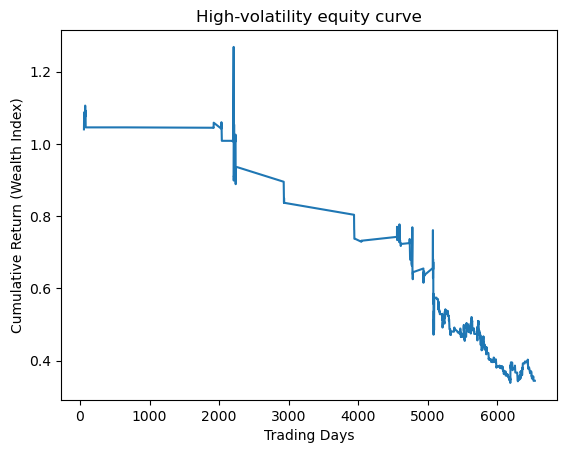

In [135]:
equity_high_vol = (1 + df.loc[df["ATR"] > df["ATR"].quantile(0.75), "NetStrategyReturn"].fillna(0)).cumprod()
plt.plot(equity_high_vol)
plt.title("High-volatility equity curve")
plt.xlabel("Trading Days")
plt.ylabel("Cumulative Return (Wealth Index)")
plt.show()

Conditioning the strategy on high-volatility regimes alters the equity curve dynamics
but does not improve long-run performance. While isolated periods of strong performance
are observed during sustained volatility expansions, these gains are quickly reversed
during choppy high-volatility environments. The resulting equity curve exhibits plateau
phases, abrupt drawdowns, and stair-step declines, indicating that volatility alone
does not identify persistent directional opportunities. This suggests that trend
persistence, rather than volatility magnitude, is the critical missing component.


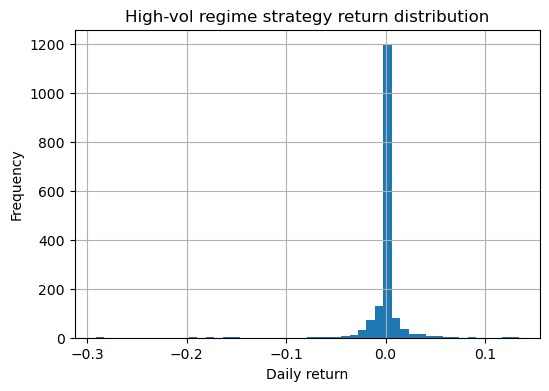

In [137]:
plt.figure(figsize=(6,4))
df.loc[df["ATR"] > df["ATR"].quantile(0.75), "NetStrategyReturn"].hist(bins=50)
plt.title("High-vol regime strategy return distribution")
plt.xlabel("Daily return")
plt.ylabel("Frequency")
plt.show()

The distribution of daily net strategy returns under high-volatility regimes
retains the same basic shape as the unconditional strategy: a large mass
near zero, occasional small losses, and rare positive returns. The only
difference is that trades occur less frequently, reflecting the reduced
number of days that meet the high-volatility filter. Overall, high volatility
alone does not improve the expected performance of the strategy.
